This notebook was constructed using Python 3.

# Raw data

The following data set contains various customer information including whether the customer responded to a marketing campaign or not (the `responded` column). 


In [1]:
import pandas as pd
pd.set_option('max_columns', 200)
def read_csv(filename): 
    return pd.read_csv(filename)
df = read_csv('marketing_training.csv')
df.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,5,999,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


Here are the descriptions of each column: 
![title](column_descriptions.png)

# Data cleaning
### Unknown and nonexistent
I noticed some predictors took on the values `unknown` and `nonexistent`:

In [2]:
df.profession.unique()

array(['admin.', 'blue-collar', 'technician', 'management', 'services',
       'unemployed', 'housemaid', 'unknown', 'self-employed', 'retired',
       'student', 'entrepreneur'], dtype=object)

In [3]:
df.poutcome.unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

These values are equivalent to missing data, which is represented by `NaN` in pandas. I therefore replaced these special values with `NaN`: 

In [4]:
import numpy as np
df = df.replace('unknown', np.nan)
df = df.replace('nonexistent', np.nan)

### Redundant columns (collinearity) 

The variables `pdays` and `pmonths` are perfectly correlated so one should be removed. I find it easier to count days in whole numbers than in fractions of a month, so I dropped the `pmonths` column: 

In [5]:
df = df.drop('pmonths',axis=1)

### Contact in a previous campaign

I noticed that customers who were not contacted in a previous campaign were assigned the number 999 in the `pdays` column. In reality, values for this predictor variable are only defined for customers who were previously contacted. 

One approach is to partition the data into two sets: customers who were or were not contacted in a previous campaign. The partition containing customers who were contacted would contain a `pdays` column while the other partition wouldn't. One could then train predictive models on each partition and use the appropriate model to make predictions. I decided against this approach, in the first analysis, because the training set size for customers who were previously contacted was so small (not shown). The learning curves that I plot below confirm that such small data sets suffer from high variance. 

The alternative approach is to introduce a predictor boolean variable to indicate whether a customer was or was not contacted in a previous campaign. Though this approach suffers from ambiguity in the choice of `pdays` for those customers who were not previously contacted, it does alleviate concerns about small training set size. 




In [6]:
# True and False are equivalent to 1 and 0 in numerical computations
df['previously_contacted'] = df.pdays!=999 

The creation of an additional feature to indicate previous contact is especially important given that the target variable appears to be highly correlated with it. Concretely, customers who were contacted in a previous campaign were more likely to respond well to the current marketing campaign:   

In [7]:
def target_variable(was_previously_contacted): 
    return df[df.previously_contacted==was_previously_contacted].responded.head(10)

target_variable(was_previously_contacted=True)   

21     yes
69     yes
108    yes
125    yes
184    yes
190     no
196     no
238    yes
241     no
304    yes
Name: responded, dtype: object

In [8]:
target_variable(was_previously_contacted=False)   

0     no
1     no
2     no
3     no
4     no
5     no
6    yes
7     no
8     no
9     no
Name: responded, dtype: object

The current value of `pdays` for customers who were not contacted in a previous campaign (999) is problematic. 999 is quite distant from the  valid range of values of `pdays`, which is 0 - 22: 


In [9]:
df.pdays.unique()

array([999,   6,   7,   5,   1,   3,  10,  15,   2,  22,  14,   4,   9,
        11,  12,  13,   8,  16,   0,  17,  21])

This implies that most of the dynamic range is uninformative. 

A better special value for `pdays` is one that is closer to the valid range but obviously non-valid, such as -1: 

In [10]:
df.loc[df.pdays==999, 'pdays'] = -1

# Categorical data 

* **One-hot encoding**
Categorical variables need to be encoded before feeding them into a learning algorithm that expects numerical input. One cannot assign scalars to each categorical value because that would impose an arbitrary and meaningless order to the values. Instead, one should expand the feature space to include features for each possible value of the categorical variable. The usual way to do this is termed one-hot encoding: each categorical value becomes a vector in which the component corresponding to the variable's value is set to 1 (i.e made "hot") while the other components are set to 0. 
* **Missing values**
In the first instance I chose to consider missing categorical data as just another value (`NaN`) for the categorical variable. This way, if the data were not missing at random, then I ought to be able to detect this in my model. 

* **Collinearity**
I dropped the first column in each one-hot encoding of a categorical variable in order to prevent collinearity (column dependency). 


In [11]:
def one_hot_encode(data_frame): 
    data_frame = pd.get_dummies(data_frame, dummy_na=True, drop_first=True)
    # https://stackoverflow.com/questions/21164910/delete-column-in-pandas-if-it-is-all-zeros:  
    return data_frame.loc[:, (data_frame != 0).any(axis=0)] 

df = one_hot_encode(df)
df.head()

,custAge,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pastEmail,previously_contacted,profession_blue-collar,profession_entrepreneur,profession_housemaid,profession_management,profession_retired,profession_self-employed,profession_services,profession_student,profession_technician,profession_unemployed,profession_nan,marital_married,marital_single,marital_nan,schooling_basic.6y,schooling_basic.9y,schooling_high.school,schooling_illiterate,schooling_professional.course,schooling_university.degree,schooling_nan,default_yes,default_nan,housing_yes,housing_nan,loan_yes,loan_nan,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,day_of_week_nan,poutcome_success,poutcome_nan,responded_yes
0,55.0,1,-1,0,-0.1,93.200,-42.0,4.191,5195.8,0,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,NaN,1,-1,0,1.4,93.918,-42.7,4.960,5228.1,0,False,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,42.0,1,-1,0,1.1,93.994,-36.4,4.857,5191.0,0,False,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
3,55.0,2,-1,0,1.4,93.918,-42.7,4.962,5228.1,0,False,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,NaN,5,-1,1,-1.8,92.893,-46.2,1.291,5099.1,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


# Imputing missing numerical values

I first added an indicator variable to keep track of whether I imputed `custAge` for the record or not. If the fact that it is missing has a meaning (i.e. customer age is not missing at random), then its impact can be assessed by that indicator variable. Bonus advantage: others who use my pre-processed data are made aware of which variables I imputed. 

In [12]:
def track_missing_ages(data_frame): 
    data_frame['impute_age'] = data_frame['custAge'].isnull()
    return data_frame

df = track_missing_ages(df)

I next used the column mean to impute missing customer ages:



In [13]:
def impute_age(data_frame): 
    imputed_age = data_frame.mean().custAge
    data_frame['custAge'] = data_frame['custAge'].fillna(imputed_age)
    return data_frame

df = impute_age(df)

Main advantage: really simple, really fast, but not that nuanced. If time had permitted, I would have inferred the missing ages from the values of the other predictor variables using SVD plus EM, e.g. see [here](https://stackoverflow.com/questions/35577553/how-to-fill-nan-values-in-numeric-array-to-apply-svd) and [here](https://github.com/hammerlab/fancyimpute).

# Feature scaling

To prevent oscillations during gradient descent arising from non-spherical level surfaces of the loss function, I made those surfaces more spherical by scaling features to lie in the interval $(0,1)$:



In [14]:
from sklearn.preprocessing import MinMaxScaler

def extract_features_target(data_frame): 
    X = data_frame.drop('responded_yes', axis=1).values.astype(float)
    y = data_frame.responded_yes.values.astype(float)

    X_scaler = MinMaxScaler(feature_range=(0,1))
    X = X_scaler.fit_transform(X)

    return X, y

# Model training and ROC validation

I created a function `roc_analysis` that fits a classifer to a subset of the data and then cross-validates it on the remainder of the data. This fit-and-validate cycle is repeated k times (k-fold cross validation). 

The function also produces ROC curves to quantify model performance. In the presence of skewed classes, ROC curves better characterize algorithm performance than classification accuracy/error. 



In [15]:
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def parse_function_name(s):
    end = s.find( '(' )
    if end != -1:
        return s[:end]
    return 'error parsing function name'

def roc_analysis(classifier, data_frame, number_splits=5): 
    
    X, y = extract_features_target(data_frame)
    cross_validator = StratifiedKFold(n_splits=number_splits, 
                                      shuffle=True)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cross_validator.split(X, y)):
        probabilities = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probabilities[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='classifier that ignores features', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % 
             (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, 
                     color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(parse_function_name(classifier.__str__()))
    plt.legend(loc="lower right")
    plt.show()

# Logistic regression and neural networks 

It is always wise to start with a simple algorithm. The simplest classifier is logistic regression: 
 

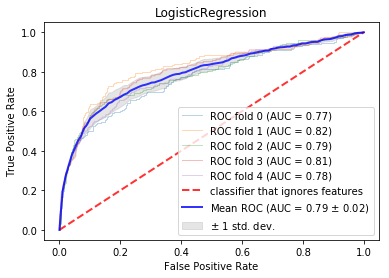

In [16]:
from sklearn.linear_model import LogisticRegression
roc_analysis(LogisticRegression(), df)

Mean area under the ROC curve (AUC) is 0.79. That's pretty good performance: it's about half-way between a classifier that ignores features (AUC = 0.5) and a perfect classifier (AUC = 1). 

Moreover, the fact that there is little variation in the ROC curves as the "fold" is varied strongly suggests that the model has low variance. Low variance can be demonstrated more formally via learning curves: 






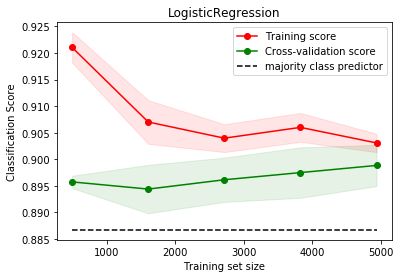

In [17]:
from sklearn.model_selection import learning_curve

def majority_class_predictor_accuracy(data_frame):
    counts = dict(data_frame.responded_yes.value_counts())
    min_counts = min(counts.values())
    max_counts = max(counts.values())
    return max_counts/float(min_counts+max_counts)

def plot_learning_curve(classifier, data_frame, ylim=None):  
    plt.title(parse_function_name(classifier.__str__()))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training set size")
    plt.ylabel("Classification Score")

    X, y = extract_features_target(data_frame)
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y)
    # average over cross validation folds:
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, 
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, 
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes, 
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, 
                     alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 
             'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 
             'o-', color="g", label="Cross-validation score")

    baseline_score = majority_class_predictor_accuracy(data_frame)
    
    plt.plot([min(train_sizes), max(train_sizes)], 
             [baseline_score, baseline_score], 
             '--', color="black", label="majority class predictor")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(LogisticRegression(), df)

After using all our training data, the model does about the same on the CV set as on the training set - that means we don't have  overfitting (the model generalized very well). 

But does the model have high bias? After all, the classification score is not that much higher than what you'd expect from a classifier that simply predicts the majority class all the time (see dashed horizontal line in the plot above). 

The only way to address the possibility that there is high bias is to increase the model's complexity and see whether CV performance goes up. Logistic regression can be viewed as a neural network with no hidden layers. I therefore next considered a net with one hidden layer. With that increase in model complexity comes an increase in variance, which I corrected by cranking up the regularization ($\alpha$ term in the code that follows): 


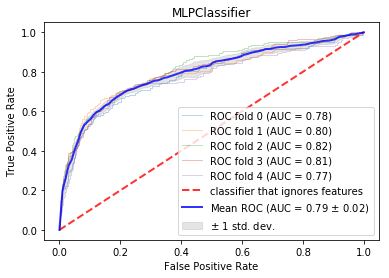

In [18]:
from sklearn.neural_network import MLPClassifier
roc_analysis(MLPClassifier(hidden_layer_sizes=(100), alpha=1), df) 

Wow! The area under the curve hardly changed. This suggests that the original logistic regression model is not suffering from high bias. 

# Other models

I wondered whether topologically different models might out-perform the simple logistic regression model. Neither of the two models I tried (support vector machine and decision tree) did: 

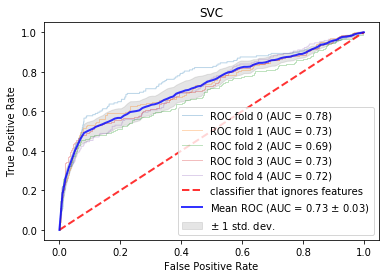

In [19]:
from sklearn.svm import SVC
roc_analysis(SVC(probability=True), df)

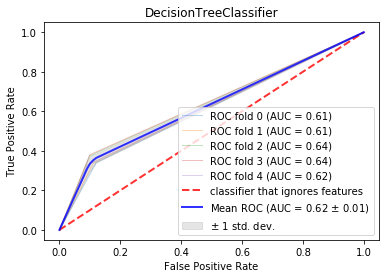

In [20]:
from sklearn.tree import DecisionTreeClassifier
roc_analysis(DecisionTreeClassifier(), df)

# Putting it all together 

I collected all of the sanitizing operations I describe above into a single function, `sanitize`, in order to sanitize the training and test data in a similar way. 



In [21]:
def sanitize(data_frame):
    data_frame = data_frame.replace('unknown', np.nan)
    data_frame = data_frame.replace('nonexistent', np.nan)
    data_frame = data_frame.drop('pmonths',axis=1)
    data_frame['previously_contacted'] = data_frame.pdays!=999 
    data_frame.loc[data_frame.pdays==999, 'pdays'] = -1
    data_frame = track_missing_ages(data_frame)
    data_frame = impute_age(data_frame)
    return data_frame

The list of values that a categorical variable assumed in the training and test sets were not perfectly coincident. I dealt with this by concatenating the sets, applying one-hot encoding on the concatenation, and then unpacking the concatenation into one-hot-encoded training and test sets. 



In [22]:
def get_values(data_frame): 
    return data_frame.values.astype(float)

def encode_train_test(): 
    df_train = sanitize(read_csv('marketing_training.csv'))
    df_train_X = df_train.drop('responded', axis=1)
    df_train_y = one_hot_encode(pd.DataFrame(df_train['responded']))

    df_test_X = sanitize(read_csv('marketing_test.csv')).drop('Unnamed: 0', axis=1)

    df_X = pd.concat([df_train_X, df_test_X])
    df_X = one_hot_encode(df_X)
    split = len(df_train_X)
    df_train_X = df_X[:split]
    df_test_X = df_X[split:]
        
    return (get_values(df_train_X), 
            get_values(df_train_y), 
            get_values(df_test_X))

I re-trained the logistic regression model on the entire training set to predict whether customers in the test set responded favorably to the current marketing campaign. I then saved the data in a csv file in the same format as the training data. 

In [23]:
def compute_normalized_X_y(): 
    X_train, y_train, X_test = encode_train_test() 
    X_scaler = MinMaxScaler(feature_range=(0,1))
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, y_train, X_test

def convert_to_yes_or_no(x): 
    if int(x) == 0: 
        return 'no'
    else: 
        return 'yes'

def predict_with_final_model():
    X_train, y_train, X_test = compute_normalized_X_y()
    final_model = LogisticRegression()
    predictions = final_model.fit(X_train, y_train.ravel()).predict(X_test)
    predictions = list(map(convert_to_yes_or_no, predictions))

    df_test = read_csv('marketing_test.csv')
    df_test['responded'] = predictions
    df_test.to_csv('marketing_test_with_predictions.csv')
    
predict_with_final_model()